## Importação

In [52]:
import numpy as np
import seaborn as sb
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
%matplotlib inline
from sklearn.preprocessing import Normalizer, LabelEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split, KFold
from sklearn.manifold import TSNE
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

## Pegando DataSet

In [53]:
df = pd.read_csv('./SRC/titanic/train.csv', sep=',')
df_test = pd.read_csv('./SRC/titanic/test.csv', sep=',')
y_test = pd.read_csv('./SRC/titanic/gender_submission.csv', sep=',')

In [54]:
y_test = y_test['Survived']

## Análise dos dados

Primeiro passo é excluir colunas que em nenhuma hipótese ferão diferença

In [55]:
df = df.drop(columns=['PassengerId', 'Name', 'Cabin'])
df_test = df_test.drop(columns=['PassengerId', 'Name', 'Cabin'])

Segundo passo foi transformar todos os dados categoricos em numericos

<AxesSubplot:xlabel='Embarked', ylabel='count'>

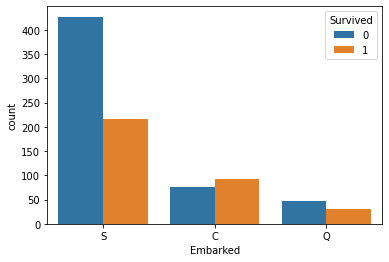

In [56]:
sb.countplot(data=df, x='Embarked', hue='Survived')

<AxesSubplot:xlabel='Pclass', ylabel='count'>

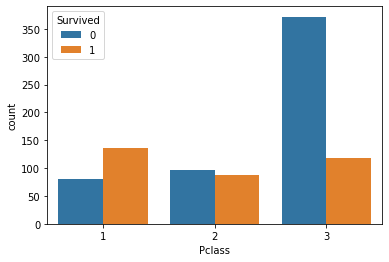

In [57]:
sb.countplot(data=df, x='Pclass', hue='Survived')

<AxesSubplot:xlabel='Sex', ylabel='count'>

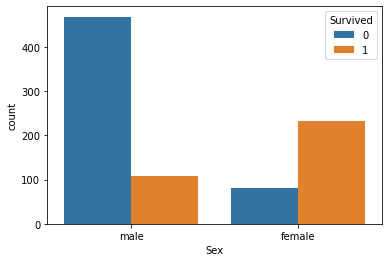

In [58]:
sb.countplot(data=df, x='Sex', hue='Survived')

Depois de alguns da análise, percebi que alguns dados não são tão relevantes(Fare, Ticket), alguns dados são redundantes(Embarked, a diferença no plot é devido alguns passageiros de primeira classe embarcaram em ponto específico) e por ultimos os dados da Cabin são muito importantes, porém escassos, farei teste substituindo os faltantes por um valor 0 e outro excluindo esta coluna.

In [59]:
df = df.drop(columns=['Embarked', 'Ticket', 'Fare'])
df_test = df_test.drop(columns=['Embarked', 'Fare', 'Ticket'])

## Tratamento de dados

In [60]:
df = df.fillna('0')
df_test = df_test.fillna('0')

In [61]:
labelencoder = LabelEncoder()

df['Sex'] = labelencoder.fit_transform(df['Sex'])
df_test['Sex'] = labelencoder.fit_transform(df_test['Sex'])

In [62]:
X_train, X_test = df.drop(columns=['Survived']), df_test
y_train = df['Survived']

## Training classifiers

### Selecting models and names

In [63]:
models = {
    'knn': KNeighborsClassifier(),
    'decision_tree': DecisionTreeClassifier(),
    'random_forest': RandomForestClassifier(),
    'svc': SVC(),
    'mlp': MLPClassifier(),
    'bayes': GaussianNB()
}

In [64]:
names_models = {
    'knn': 'KNeighborsClassifier',
    'decision_tree': 'DecisionTreeClassifier',
    'random_forest': 'RandomForestClassifier',
    'svc': 'SVC',
    'mlp': 'MLPClassifier',
    'bayes': 'GaussianNB'
}

### Training

In [65]:
accuracies = []
classifiers = []
for i in models:
    clf = models[i].fit(X_train, y_train)
    y_predict = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_predict)
    print(f'Accuracy {names_models[i]} = {accuracy_score(y_test, y_predict)}')
    accuracies.append(accuracy)
    classifiers.append(names_models[i])

Accuracy KNeighborsClassifier = 0.7918660287081339
Accuracy DecisionTreeClassifier = 0.7870813397129187
Accuracy RandomForestClassifier = 0.8038277511961722
Accuracy SVC = 0.6363636363636364
Accuracy MLPClassifier = 0.9449760765550239
Accuracy GaussianNB = 0.868421052631579


/home/geovanebarros/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


### Plot results

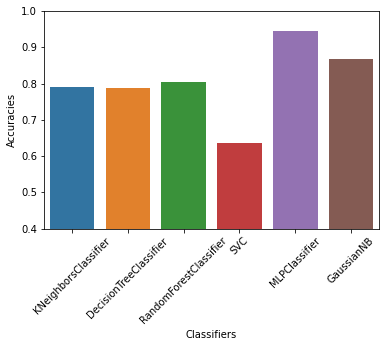

In [66]:
dataframe = pd.DataFrame({
    'Classifiers': classifiers,
    'Accuracies':accuracies
})
ax = sb.barplot(data=dataframe, x='Classifiers', y='Accuracies')
ax.set(ylim=(0.4,1))
ax.tick_params(axis='x', rotation=45)

## Improving classifier

### Selecting best classifiers

In [67]:
names_models = {
    'knn': 'KNeighborsClassifier',
    'decision_tree': 'DecisionTreeClassifier',
    'random_forest': 'RandomForestClassifier',
    'svc': 'SVC',
    'mlp': 'MLPClassifier',
}

In [78]:
params = {
    'knn': {'n_neighbors':[1,3,5,7]},
    'decision_tree':{'criterion': ['gini','entropy'], 'splitter':['best', 'random']},
    'random_forest': {'criterion': ['gini','entropy'], 'n_estimators':[50,100,150,200]},
    'svc': {'kernel':['linear', 'poly', 'rbf', 'sigmoid'], 'gamma':['scale','auto'], 'degree':[2,3,4]},
    'mlp': {'solver':['sgd', 'adam'], 'hidden_layer_sizes':[(100,), (50,50), (100,50)], 'max_iter':[1000]},
}

### RandomSearch to find the best classifiers and params

In [79]:
best_accuracy = 0

for i in models:
    clf = RandomizedSearchCV(models[i], params[i], n_iter=4).fit(X_train, y_train)
    y_predict = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_predict)
    print(f'Accuracy {names_models[i]} = {accuracy_score(y_test, y_predict)}')
    print(f'Best params {clf.best_params_}')
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_classifier = clf

Accuracy KNeighborsClassifier = 0.7727272727272727
Best params {'n_neighbors': 7}
Accuracy DecisionTreeClassifier = 0.7990430622009569
Best params {'criterion': 'entropy'}


/home/geovanebarros/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:285: UserWarning: The total space of parameters 2 is smaller than n_iter=4. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Accuracy RandomForestClassifier = 0.8205741626794258
Best params {'n_estimators': 100, 'criterion': 'gini'}


## Checking whether normalization and standardization have an effect

In [ ]:
X_train_normalized = Normalizer().fit(X_train).transform(X_train)
X_test_normalized = Normalizer().fit(X_test).transform(X_test)
X_train_standard = Normalizer().fit(X_train).transform(X_train)
X_test_standard = Normalizer().fit(X_test).transform(X_test)

## Salvando o melhor modelo

In [70]:
import os
save_models_path = './results'
if not os.path.exists(save_models_path):
    os.mkdir(save_models_path)

In [71]:
import joblib
import glob

O melhor classificador foi o MLP, ele será salvo.

In [72]:
filename = save_models_path+'/titanic.pkl'
joblib.dump(clf,filename)

['./results/titanic.pkl']

In [73]:
modelo_load = joblib.load('./results/titanic.pkl')

In [74]:
accuracy_score(y_test, modelo_load.predict(X_test))

0.6339712918660287